In [1]:
import cv2
import numpy as np
from sklearn.utils import shuffle
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from utils.utils import load_dataset, download_dataset, create_cnn_model, get_callbacks, get_preds, show_train_loss_accuracy, show_metrics, INPUT_SHAPE, OUTPUT_CLASSES
%matplotlib inline
warnings.filterwarnings('ignore')

2025-10-01 11:48:44.345586: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-01 11:48:44.874828: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cenzi/Área de trabalho/Aulas/tcc/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/cenzi/Área de trabalho/Aulas/tcc/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exa

In [2]:
DATA_PATH = "./data"
TEST_PATH = "./data"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(TEST_PATH, "test")

In [3]:
X_train, y_train, LABEL_MAP = load_dataset(TRAIN_PATH)
X_test, y_test, _ = load_dataset(TEST_PATH)

X_train.shape, y_train.shape, LABEL_MAP

((28709, 48, 48, 3),
 (28709,),
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

In [4]:
# Resize images from 48x48 to 144x144
import cv2

X_train = np.array([cv2.resize(img, (144, 144)) for img in X_train])
X_test = np.array([cv2.resize(img, (144, 144)) for img in X_test])
X_train.shape, X_test.shape


((28709, 144, 144, 3), (7178, 144, 144, 3))

In [5]:

from tensorflow.keras.models import load_model

OUTPUT_CLASSES = 7
INPUT_SHAPE = (144, 144, 3)

model = load_model('ResNet50v2/best_ResNet50v2_model_basic.keras')

2025-10-01 11:48:58.185455: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
from tensorflow.keras.utils import to_categorical

BATCH_SIZE = 32
EPOCHS = 60
histories = {}

# Normaliza
X_train_resized = X_train.astype("float32") / 255.0
X_test_resized = X_test.astype("float32") / 255.0

# One-hot
y_train_cat = to_categorical(y_train, num_classes=OUTPUT_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=OUTPUT_CLASSES)

In [7]:
iteration = 0
while True:
    iteration += 1
    print(f"--- Iteration {iteration} ---")
    print("STRAT TRAINING MODEL Reclassificacao...")
    histories['Reclassificacao'] = model.fit(X_train_resized, y_train_cat,
                                     validation_split=0.2,
                                     epochs=EPOCHS,
                                     batch_size=BATCH_SIZE,
                                     callbacks=get_callbacks('Reclassificacao'))
    print(f"FINISH TRAINING MODEL Reclassificacao!")
    print("---------------------------------------------------------------")
    
    #show_train_loss_accuracy(histories['Reclassificacao'])
    
    # Get accuracy in train set
    train_preds = get_preds(X_train_resized, model)
    train_acc = np.sum(train_preds == y_train) / len(y_train)
    print(f"Train Accuracy: {train_acc*100:.2f}%")
    
    # Select only the right predictions
    right_indices = np.where(train_preds == y_train)[0]
    X_train_resized = X_train_resized[right_indices]
    y_train_cat = y_train_cat[right_indices]
    y_train = y_train[right_indices]
    
    # Get accuracy in test set
    test_preds = get_preds(X_test_resized, model)
    test_acc = np.sum(test_preds == y_test) / len(y_test)
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    
    #show_metrics(y_test, test_preds, LABEL_MAP)
    
    if train_acc >= 0.93:
        break

--- Iteration 1 ---
STRAT TRAINING MODEL Reclassificacao...


2025-10-01 11:49:22.633691: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 5714924544 exceeds 10% of free system memory.


Epoch 1/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5902 - loss: 1.1467

2025-10-01 11:55:14.419984: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1428793344 exceeds 10% of free system memory.


718/718 ━━━━━━━━━━━━━━━━━━━━ 402s 545ms/step - accuracy: 0.5960 - loss: 1.1373 - val_accuracy: 0.6850 - val_loss: 0.9245 - learning_rate: 1.0000e-06
Epoch 2/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 379s 528ms/step - accuracy: 0.5974 - loss: 1.1334 - val_accuracy: 0.6876 - val_loss: 0.9200 - learning_rate: 1.0000e-06
Epoch 3/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 378s 527ms/step - accuracy: 0.6030 - loss: 1.1149 - val_accuracy: 0.6909 - val_loss: 0.9046 - learning_rate: 1.0000e-06
Epoch 4/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 379s 527ms/step - accuracy: 0.6020 - loss: 1.1086 - val_accuracy: 0.6945 - val_loss: 0.8993 - learning_rate: 1.0000e-06
Epoch 5/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 380s 530ms/step - accuracy: 0.6080 - loss: 1.0929 - val_accuracy: 0.6959 - val_loss: 0.8943 - learning_rate: 1.0000e-06
Epoch 6/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 380s 530ms/step - accuracy: 0.6103 - loss: 1.0867 - val_accuracy: 0.6977 - val_loss: 0.8908 - learning_rate: 1.0000e-06
Epoch 7/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 383s 533ms/

2025-10-01 16:14:33.767443: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 7143717888 exceeds 10% of free system memory.


898/898 ━━━━━━━━━━━━━━━━━━━━ 381s 419ms/step
Train Accuracy: 71.84%


2025-10-01 16:22:24.476573: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1786116096 exceeds 10% of free system memory.


225/225 ━━━━━━━━━━━━━━━━━━━━ 91s 405ms/step
Test Accuracy: 53.79%
--- Iteration 2 ---
STRAT TRAINING MODEL Reclassificacao...


2025-10-01 16:23:58.739168: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 4105479168 exceeds 10% of free system memory.


Epoch 1/60
516/516 ━━━━━━━━━━━━━━━━━━━━ 271s 522ms/step - accuracy: 0.7986 - loss: 0.6278 - val_accuracy: 0.9775 - val_loss: 0.4397 - learning_rate: 1.0000e-10
Epoch 2/60
516/516 ━━━━━━━━━━━━━━━━━━━━ 268s 519ms/step - accuracy: 0.7999 - loss: 0.6284 - val_accuracy: 0.9748 - val_loss: 0.4434 - learning_rate: 1.0000e-10
Epoch 3/60
516/516 ━━━━━━━━━━━━━━━━━━━━ 267s 517ms/step - accuracy: 0.8031 - loss: 0.6256 - val_accuracy: 0.9789 - val_loss: 0.4353 - learning_rate: 1.0000e-10
Epoch 4/60
516/516 ━━━━━━━━━━━━━━━━━━━━ 265s 513ms/step - accuracy: 0.7991 - loss: 0.6316 - val_accuracy: 0.9784 - val_loss: 0.4381 - learning_rate: 1.0000e-10
Epoch 5/60
516/516 ━━━━━━━━━━━━━━━━━━━━ 264s 512ms/step - accuracy: 0.7959 - loss: 0.6292 - val_accuracy: 0.9794 - val_loss: 0.4392 - learning_rate: 1.0000e-10
Epoch 6/60
516/516 ━━━━━━━━━━━━━━━━━━━━ 262s 508ms/step - accuracy: 0.8008 - loss: 0.6264 - val_accuracy: 0.9782 - val_loss: 0.4391 - learning_rate: 1.0000e-10
Epoch 7/60
516/516 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
X_train, y_train, LABEL_MAP = load_dataset(TRAIN_PATH)
X_test, y_test, _ = load_dataset(TEST_PATH)

X_train.shape, y_train.shape, LABEL_MAP

((28709, 48, 48, 3),
 (28709,),
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

In [12]:
X_train = np.array([cv2.resize(img, (144, 144)) for img in X_train])
X_test = np.array([cv2.resize(img, (144, 144)) for img in X_test])
X_train.shape, X_test.shape

((28709, 144, 144, 3), (7178, 144, 144, 3))

In [13]:
# Normaliza
X_train_resized = X_train.astype("float32") / 255.0
X_test_resized = X_test.astype("float32") / 255.0

# One-hot
y_train_cat = to_categorical(y_train, num_classes=OUTPUT_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=OUTPUT_CLASSES)

In [14]:
# Reclassificar o dataset completo, separado por treino e teste

preds = model.predict(X_train_resized)
new_y_train = np.argmax(preds, axis=1)

# print new_y_train distribution
(unique, counts) = np.unique(new_y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print("New y_train distribution:")
print(frequencies)



898/898 ━━━━━━━━━━━━━━━━━━━━ 378s 418ms/step
New y_train distribution:
[[   0 4056]
 [   1  789]
 [   2 3519]
 [   3 6301]
 [   4 5567]
 [   5 5185]
 [   6 3292]]


In [15]:
#compare old y_train distribution with new_y_train distribution
(old_unique, old_counts) = np.unique(y_train, return_counts=True)
old_frequencies = np.asarray((old_unique, old_counts)).T
print("Old y_train distribution:")
print(old_frequencies)
print("New y_train distribution:")
print(frequencies)

Old y_train distribution:
[[   0 3995]
 [   1  436]
 [   2 4097]
 [   3 7215]
 [   4 4965]
 [   5 4830]
 [   6 3171]]
New y_train distribution:
[[   0 4056]
 [   1  789]
 [   2 3519]
 [   3 6301]
 [   4 5567]
 [   5 5185]
 [   6 3292]]


In [16]:
# print how many images change class
print(f"Number of images that changed class: {np.sum(y_train != new_y_train)}")

Number of images that changed class: 8196


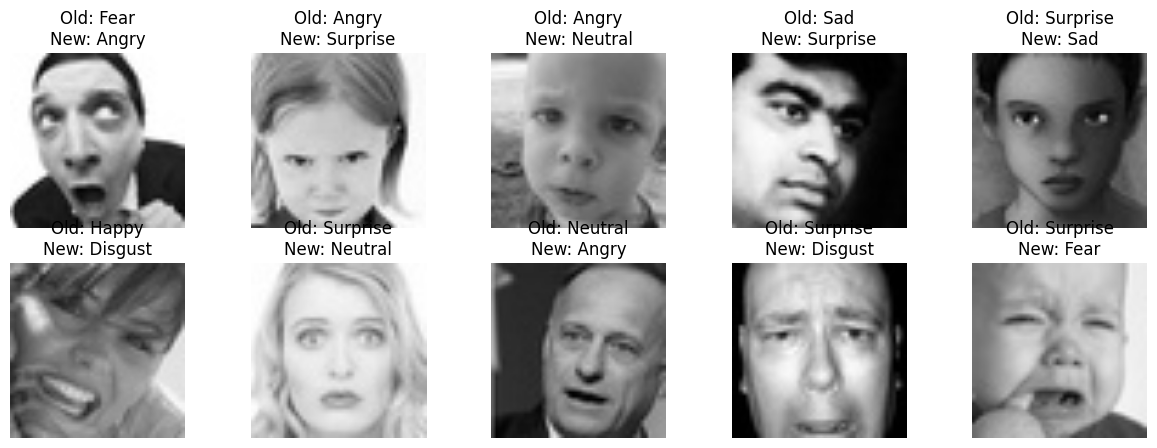

In [18]:
# plot images that changed class with their old and new labels
LABEL_MAP = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}
changed_indices = np.where(y_train != new_y_train)[0]
num_changed = len(changed_indices)
num_to_plot = min(10, num_changed)  # plot at most 10 images
plt.figure(figsize=(15, 5))
for i in range(num_to_plot):
    idx = changed_indices[i]
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(f"Old: {LABEL_MAP[y_train[idx]]}\nNew: {LABEL_MAP[new_y_train[idx]]}")
    plt.axis('off')

In [19]:
# desnormalizar as imagens
X_train_desnormalized = (X_train_resized * 255).astype(np.uint8)
X_test_desnormalized = (X_test_resized * 255).astype(np.uint8)

# redimensionar para 48x48
X_train_final = np.array([cv2.resize(img, (48, 48)) for img in X_train_desnormalized])
X_test_final = np.array([cv2.resize(img, (48, 48)) for img in X_test_desnormalized])
X_train_final.shape, X_test_final.shape

((28709, 48, 48, 3), (7178, 48, 48, 3))

In [23]:
#salvar os novos datasets na pasta data_reclassified como imagens jpg
import os
os.makedirs('data_reclassified/train', exist_ok=True)
os.makedirs('data_reclassified/test', exist_ok=True)
for i in range(len(X_train_final)):
    label = new_y_train[i]
    label = (LABEL_MAP[label].lower())
    label_dir = os.path.join('data_reclassified/train', str(label))
    os.makedirs(label_dir, exist_ok=True)
    cv2.imwrite(os.path.join(label_dir, f"{i}.jpg"), X_train_final[i])
for i in range(len(X_test_final)):
    label = y_test[i]
    label = (LABEL_MAP[label].lower())
    label_dir = os.path.join('data_reclassified/test', str(label))
    os.makedirs(label_dir, exist_ok=True)
    cv2.imwrite(os.path.join(label_dir, f"{i}.jpg"), X_test_final[i])

print("New datasets saved in 'data_reclassified' folder.")

New datasets saved in 'data_reclassified' folder.
